# 1. Introduction

Task: Predict future sales of a number of shops and items from current data

Method: Start by analysing the data and seeing if any of the features need to be further engineered, then test out with several machine learning frameworks, including XGBT and NNs

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 40)
warnings.filterwarnings("ignore")

C:\Users\Kai En\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\Kai En\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=T

# 2 Exploratory Data Analysis

In [2]:
test = pd.read_csv('test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## 2.1 Preparing category/item information

### 2.1.1 Creating category groups

In [3]:
categories = pd.read_csv('./English/categories.csv')
pd.DataFrame(categories.category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Headsets / Headphones,Accessories - PS2,Accessories - PS3,Accessories - PS4
1,Accessories - PSP,Accessories - PSVita,Accessories - XBOX 360,Accessories - XBOX ONE
2,Tickets (Digital),Delivery of goods,Game consoles - PS2,Game consoles - PS3
3,Game consoles - PS4,Game consoles - PSP,Game consoles - PSVita,Game consoles - XBOX 360
4,Game consoles - XBOX ONE,Game consoles - Others,Games - PS2,Games - PS3
5,Games - PS4,Games - PSP,Games - PSVita,Games - XBOX 360
6,Games - XBOX ONE,Games - Game accessories,Android games - Number,MAC Games - Number
7,PC Games - Additional Editions,PC Games - Collector's Editions,PC Games - Standard Editions,PC Games - Digital
8,"Payment Cards (Cinema, Music, Games)",Payment Cards - Live!,Payment Cards - Live! (Digital),Payment cards - PSN
9,Payment cards - Windows (Digital),Cinema - Blu-Ray,Cinema - Blu-Ray 3D,Cinema - Blu-Ray 4K


Main TODOs: Look for outliers, cluster similar shops, mean encode categorical features

In [4]:
#create broader category groupings
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
categories[categories['group_name']=='Payment cards'] = 'Payment Cards'
#label encode group names
categories['group_id']  = le.fit_transform(categories.group_name.values)
categories.sample(5)

,category_name,category_id,group_name,group_id
65,Gifts - Board games (compact),65,Gifts,9
41,Cinema - Collector's,41,Cinema,5
74,Programs - MAC (Digit),74,Programs,15
9,Delivery of goods,9,Delivery of goods,6
4,Accessories - PSP,4,Accessories,0


In [5]:
np.unique(categories['group_name'].values)

array(['Accessories', 'Android games', 'Batteries', 'Blank media',
       'Books', 'Cinema', 'Delivery of goods', 'Game consoles', 'Games',
       'Gifts', 'MAC Games', 'Music', 'PC', 'PC Games', 'Payment Cards',
       'Programs', 'Service', 'Tickets'], dtype=object)

In [6]:
#load items
items = pd.read_csv('./English/items.csv')

items.sample(10)

,item_id,category_id,item_name
10447,10447,40,PUZZLE
9881,9881,55,VINTAGE of Mickey (firms.)
4486,4486,19,"Lollipop Chainsaw [PS3, Russian subt..."
15220,15220,63,Soft toy Adventure Time Finn mini wi...
9263,9263,66,Brilliant cat stickers and rings
20590,20590,72,Figurine Kingdom Hearts Riku
5185,5185,67,Nanoblock Triceratops
17327,17327,40,GHOST. OSCAR COLLECTION
9124,9124,54,"BUCH1S, №4, April 2015 [Digital vers..."
766,766,78,1C: Cognitive collection. We collect...


### 2.2.2 Cleaning item names and creating item name features

In [7]:
#clean item_name
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']
                              
#label encode these columns
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

#join category_name, group_name and group_id to items
items = items.join(categories.set_index('category_id'), on='category_id')
items.sample(20)

,item_id,category_id,item_name,item_name_first4,item_name_first6,item_name_first11,category_name,group_name,group_id
9930,9930,40,all heavies season 2dvd,210,341,552,Cinema - DVD,Cinema,5.0
21259,21259,61,shirt order 1886 photo xl,3030,5480,9788,Gifts - Attributes,Gifts,9.0
19205,19205,37,super mike xxl bd,3239,5932,10624,Cinema - Blu-Ray,Cinema,5.0
13370,13370,49,compvopsertexam1s accounting rev...,772,1426,2597,Books - Methodological materials 1C,Books,4.0
560,560,77,1c educational collection english ...,37,47,68,Programs - Educational,Programs,15.0
12381,12381,55,kalinov most gold pigments firms,1696,3073,5540,Music - CD of local production,Music,11.0
8261,8261,40,american history region,230,371,589,Cinema - DVD,Cinema,5.0
4719,4719,30,mad max pc jewel russian subtitles,1964,3560,6365,PC Games - Standard Editions,PC Games,13.0
7442,7442,55,roxidance mixed by rock shocker...,2829,5068,9075,Music - CD of local production,Music,11.0
15179,15179,72,model tank 72 iraq 72,2119,3883,6955,Gifts - Figures,Gifts,9.0


### 2.2.3 Removing duplicate items

In [8]:
dupes = items[(items.duplicated(subset=['item_name','category_id'],keep=False))]
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
#dupes = dupes.groupby('item_name')
dupe_items = dupes['item_name'].unique()

#dupes.apply(print)
item_map = {}
for dupe_item in dupe_items:
    x = dupes[dupes['item_name']==dupe_item]
    intests = []
    for _, row in x.iterrows():
        if row['in_test']:
            intests.append(row['item_id'])
    
    if len(intests) == 1:
        idx = x[x['in_test']].item_id.values[0]
        for _, row in x.iterrows():
            if row['item_id'] != idx:
                item_map[row['item_id']] = idx
    elif len(intests) == 0:
        idx = x.iloc[0]['item_id']
        for _, row in x.iterrows():
            if row['item_id'] != idx:
                item_map[row['item_id']] = idx   

In [9]:
len(item_map)

650

## 2.2 Preparing Sales Information

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
sales = pd.read_csv('sales_train.csv')

In [12]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
shops = pd.read_csv('./English/shops.csv')

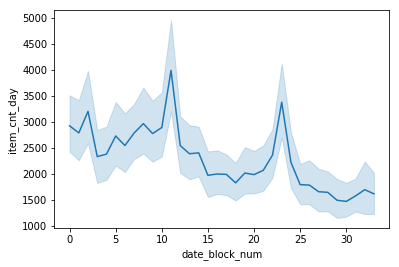

In [14]:
data = sales.groupby(['date_block_num','shop_id']).agg('sum').reset_index().astype('float')
sns.lineplot(data=data, x='date_block_num', y='item_cnt_day')

In [15]:
#loading sales data
sales = pd.read_csv('sales_train.csv')
sales = (sales
    .query('0 < item_price < 50000 and 0 < item_cnt_day < 1001') #removing outliers
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's  
    })    
)

# TRY INCLUDING THEM FIRST
#removing shops which don't appear in the test set
#sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [16]:
sales.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,first_sale_day,revenue
605544,2013-06-03,5,54,10956,319.0,1.0,0,138,319.0
1064194,2013-11-30,10,13,17253,250.0,1.0,5,281,250.0
2271959,2014-12-30,23,17,2293,999.0,1.0,1,672,999.0
814861,2013-08-22,7,25,17348,98.0,1.0,3,3,98.0
592330,2013-06-28,5,19,17081,399.0,1.0,4,2,399.0


In [17]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
25,0,28,1,0,4.300037,1
82,1,28,2,0,4.000000,32
139,2,28,3,0,4.605952,60
196,3,28,4,0,4.193211,91
253,4,28,5,0,4.333970,121
310,5,28,6,0,4.472819,152
367,6,28,7,0,4.287644,182
424,7,28,8,0,4.492718,213
481,8,28,9,0,4.313648,244
538,9,28,10,0,4.300037,274


In [18]:
sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum', 
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
1121284,21,37,1905,1.0,249.0,1
550491,9,47,8315,1.0,299.0,65
873867,16,2,4845,1.0,2199.0,256
77915,1,21,16720,1.0,149.0,5
630725,11,19,21407,1.0,199.0,318


## 2.3 Preparing training dataframe

In [19]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,471,0


In [20]:
#add the appropriate date_block_num value to the test set
test['date_block_num'] = 34
del test['ID']

In [21]:
#append test set to training dataframe
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [22]:
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name','group_name','category_name']), on='item_id', how='left')

In [23]:
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,category_id,item_name_first4,item_name_first6,item_name_first11,group_id
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,2,2,2,8.0
1,2,33,0,1.0,499.0,1.0,1,0,4.381749,1,37,415,720,1203,5.0
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,31,38,52,4.0
3,2,438,0,1.0,299.0,11.0,1,0,4.381749,1,45,31,38,57,4.0
4,2,471,0,2.0,798.0,2.0,1,0,4.381749,1,49,30,37,51,4.0


## 2.4 Add shop information

In [24]:
#loading shops.csv
shops = pd.read_csv('./English/shops.csv')

#clustering shops
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['category_id'].unique()]))),
    columns =['shop_id', 'category_id']
)
temp = df.groupby(['category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on=['shop_id','category_id'], how='left')
shops_cats = shops_cats.fillna(0)

In [25]:
shops_cats.head()

,shop_id,category_id,category_proportion
0,2,19,0.149417
1,2,37,0.033674
2,2,45,0.000130
3,2,49,0.009314
4,2,73,0.005569


In [26]:
temp3 = pd.merge(shops_cats, categories[['category_id', 'group_id']], on='category_id', how='left')
del temp3['category_id']
temp3 = temp3.groupby(['shop_id', 'group_id']).agg({'category_proportion': 'sum'}).reset_index()
temp3.head()

,shop_id,group_id,category_proportion
0,2,0.0,0.045105
1,2,1.0,0.000000
2,2,2.0,0.001661
3,2,3.0,0.002345
4,2,4.0,0.012636


In [27]:
hmap = temp3.pivot(index='group_id',
                        columns='shop_id',
                        values='category_proportion')

names = []
for i in range(18):
    name = categories[categories['group_id']==i].iloc[0]['group_name']
    names.append(name)

hmap.index = names

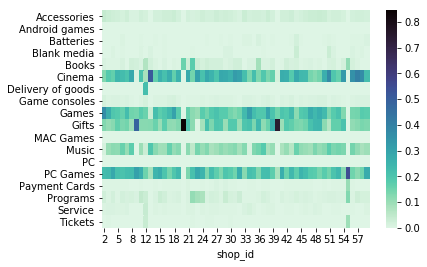

In [28]:
sns.heatmap(hmap, cmap="mako_r")

In [29]:
shops = pd.read_csv('./English/shops.csv')

shops_cats2 = shops_cats.pivot(index='shop_id', columns='category_id')
kmeans = KMeans(n_clusters=6, random_state=0).fit(shops_cats2)
shops_cats2['shop_cluster'] = kmeans.labels_.astype('int8')

#adding these clusters to the shops dataframe
shops = shops.join(shops_cats2['shop_cluster'], on='shop_id')

In [30]:
shops.groupby('shop_cluster').agg('count')

,shop_name,shop_id
shop_cluster,,
0.0,22,22
1.0,1,1
2.0,19,19
3.0,1,1
4.0,9,9
5.0,5,5


In [31]:
order = []
for i in range(6):
    t = list(shops[shops['shop_cluster']==float(i)]['shop_id'])
    print(i, t[0], t[-1])
    order += t
    
order = pd.Series(order)

0 4 59
1 55 55
2 3 53
3 20 20
4 13 58
5 2 40


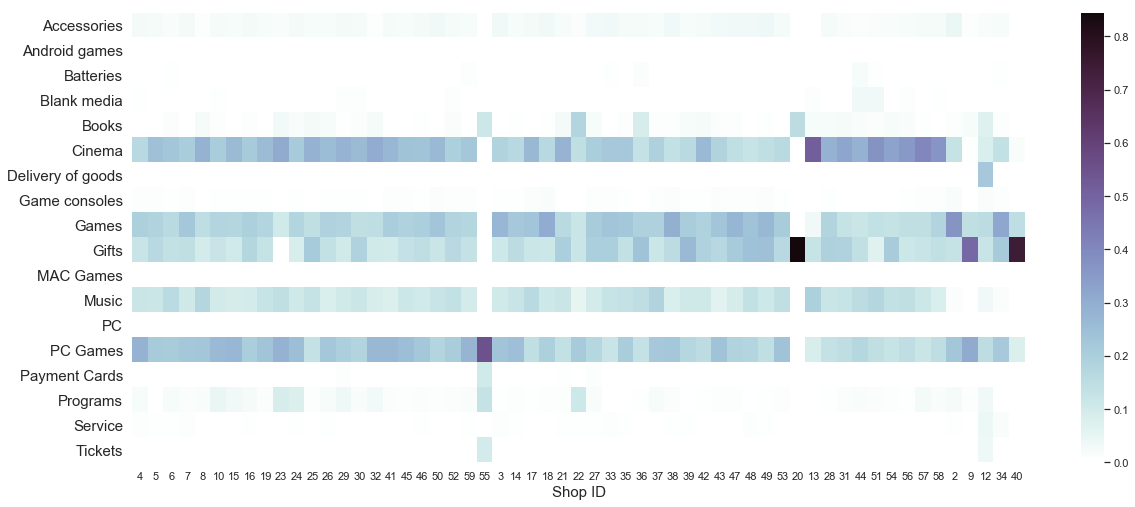

In [71]:
color = sns.cubehelix_palette(start=0.75, light=1, dark=0.05, rot=-.5, as_cmap=True)
sns.set(rc={'figure.figsize':(20,8.27)})
shop_clusters_hmap = sns.heatmap(hmap[shops.loc[order]['shop_id']], cmap=color)
shop_clusters_hmap.set_xlabel("Shop ID",fontsize=15)
#print(shop_clusters_hmap.get_ylabel())
shop_clusters_hmap.set_yticklabels(names, size = 15)
fig = shop_clusters_hmap.get_figure()
fig.savefig('./outputs/shop_clusters3.png') 

In [35]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,adygea tc mega,2,5.0,0,0
3,balashikha tc oktyabr kinomir,3,2.0,4,1
4,volga tc volga mall,4,0.0,0,25
5,vologda sec marmelad,5,0.0,2,26
6,voronezh plekhanovskaya 13,6,0.0,2,27


In [38]:
#add shop information to the training dataframe
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,2,2,2,8,5.0,0,0
1,2,33,0,1.0,499.0,1.0,1,0,4.381749,1,37,415,720,1203,5,5.0,0,0
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,31,38,52,4,5.0,0,0
3,2,438,0,1.0,299.0,11.0,1,0,4.381749,1,45,31,38,57,4,5.0,0,0
4,2,471,0,2.0,798.0,2.0,1,0,4.381749,1,49,30,37,51,4,5.0,0,0


## 2.5 Aggregating Sales/Price information

In [39]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16') # Why max and not min??
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

In [40]:
#freeing RAM, removing unneeded columns and encoding object columns
del sales, categories, shops, shops_cats, temp, temp2, test, dupes, item_map, 
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381749,19,2,2,2,8,5.0,0,0,0
1,2,33,0,1.0,499.0,1,1,0,4.381749,37,415,720,1203,5,5.0,0,0,0
2,2,317,0,1.0,299.0,4,1,0,4.381749,45,31,38,52,4,5.0,0,0,0
3,2,438,0,1.0,299.0,11,1,0,4.381749,45,31,38,57,4,5.0,0,0,0
4,2,471,0,2.0,798.0,2,1,0,4.381749,49,30,37,51,4,5.0,0,0,0


In [41]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

In [42]:
def downcast(df):
    #reduce size of the dataframe
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

In [44]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('group_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [45]:
#indicates whether shops have previously sold the item
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
#item age that stays at 0 if a shop hasn't sold the item
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
#the length of time an item has been for sale without being sold at individual shops
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

In [46]:
def agg_cnt_col(df, merging_cols, new_col,aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#individual items across all shops
df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 
#all items in category at individual shops
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'}) 
#all items in category across all shops
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})
#all items in group
df = agg_cnt_col(df, ['date_block_num','group_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
#all items in group across all shops
df = agg_cnt_col(df, ['date_block_num','group_id'],'group_cnt_all_shops',{'item_cnt':'mean'})
#all items at individual shops
df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})
#all items at all shops within the city
df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

In [47]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#mean units sold of new item in category at individual shop
df = new_item_sales(df, ['date_block_num','category_id','shop_id'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df = new_item_sales(df, ['date_block_num','category_id'], 'new_items_in_cat_all_shops')

In [48]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#average item price
df = agg_price_col(df,['date_block_num','item_id'],'item_price')
#average price of items in category
df = agg_price_col(df,['date_block_num','category_id'],'category_price')
#average price of all items
df = agg_price_col(df,['date_block_num'],'block_price')

In [49]:
df = downcast(df)

## 2.6 Time series features (lagging information)

In [50]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

In [51]:
lag12_cols = {
    'item_cnt':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops':['date_block_num', 'item_id'],
    'category_cnt':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops':['date_block_num', 'category_id'],
    'group_cnt':['date_block_num', 'shop_id', 'group_id'],
    'group_cnt_all_shops':['date_block_num', 'group_id'],
    'shop_cnt':['date_block_num', 'shop_id'],
    'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'category_id']
}
for col,merge_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to12'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

In [52]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops_median':['date_block_num', 'item_id'],
    'category_cnt_median':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops_median':['date_block_num', 'category_id']
}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_cnt_unclipped':
        del df[col]

In [53]:
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1']/df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_lag1']/df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_lag1']/df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_lag1']/df['category_cnt_all_shops_lag1to12']

In [54]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

In [55]:
df.loc[(df['item_age']>0) & (df['item_cnt_lag1to12'].isna()), 'item_cnt_lag1to12'] = 0
df.loc[(df['category_age']>0) & (df['category_cnt_lag1to12'].isna()), 'category_cnt_lag1to12'] = 0
df.loc[(df['group_age']>0) & (df['group_cnt_lag1to12'].isna()), 'group_cnt_lag1to12'] = 0

In [56]:
df['item_cnt_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[12]*len(df))]
df['item_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],[12]*len(df))]
df['category_cnt_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['category_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]
df['group_cnt_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[12]*len(df))]
df['group_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],[12]*len(df))]
df['city_cnt_lag1to12'] /= [min(idx) for idx in zip(df['date_block_num'],[12]*len(df))]
df['shop_cnt_lag1to12'] /= [min(idx) for idx in zip(df['shop_age'],[12]*len(df))]
df['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]

In [57]:
df = downcast(df)

In [58]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

#average item price in latest block item was sold
df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
#total units of item sold at individual shop
df = past_information(df, ['shop_id','item_id'],'item_cnt_sum_alltime',{'item_cnt':'sum'})
#total units of item sold at all shops
df = past_information(df, ['item_id'],'item_cnt_sum_alltime_allshops',{'item_cnt':'sum'})

#these columns are no longer needed, and would cause data leakage if retained
del df['revenue'], df['item_cnt_unclipped'], df['item_price']

In [59]:
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']

In [60]:
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [61]:
import gc
gc.collect()
df = downcast(df)

In [62]:
def matching_name_cat_age(df,n,all_shops):
    temp_cols = [f'same_name{n}catage_cnt','date_block_num', f'item_name_first{n}','item_age','category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_cnt':'mean'})
            .reset_index()
            .rename(columns={'item_cnt':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')
    return df

for n in [4,6,11]:
    for all_shops in [True,False]:
        df = matching_name_cat_age(df,n,all_shops)

In [63]:
#assign appropriate datatypes
df = downcast(df)
int8_cols = [
    'item_cnt','month','group_id','shop_type',
    'shop_city','shop_id','date_block_num','category_id',
    'item_age',
]
int16_cols = [
    'item_id','item_name_first4',
    'item_name_first6','item_name_first11'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

In [64]:
def nearby_item_data(df,col):
    if col in ['item_cnt_unclipped_lag1','item_cnt_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_cnt_unclipped_lag1','item_cnt_lag1to12',
             'item_cnt_all_shops_lag1','item_cnt_all_shops_lag1to12']
for col in item_cols:
    df = nearby_item_data(df,col)
    
del temp

## 2.7 Encoding name information

In [65]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()
for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
drop_cols = [
    'item_id','category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11',
    'category_name','group_name','group_id'
]
items = items.drop(columns=drop_cols)

In [66]:
#join these word vectors to the training dataframe
df = df.join(items, on='item_id')

In [4]:
df

,shop_id,item_id,date_block_num,item_cnt,first_sale_day,month,year,day_quality,category_id,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_age,item_name_first4_age,item_name_first6_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,item_cnt_lag1to12,item_cnt_all_shops_lag1to12,item_cnt_all_shops_lag1,item_cnt_all_shops_lag2,category_cnt_lag1to12,category_cnt_lag1,category_cnt_lag2,category_cnt_all_shops_lag1to12,category_cnt_all_shops_lag1,category_cnt_all_shops_lag2,group_cnt_lag1to12,group_cnt_lag1,group_cnt_lag2,group_cnt_all_shops_lag1to12,group_cnt_all_shops_lag1,group_cnt_all_shops_lag2,shop_cnt_lag1to12,shop_cnt_lag1,shop_cnt_lag2,city_cnt_lag1to12,city_cnt_lag1,city_cnt_lag2,new_items_in_cat_lag1to12,new_items_in_cat_lag1,new_items_in_cat_lag2,new_items_in_cat_all_shops_lag1to12,new_items_in_cat_all_shops_lag1,new_items_in_cat_all_shops_lag2,item_cnt_unclipped_lag1,item_cnt_unclipped_lag2,item_cnt_all_shops_median_lag1,item_cnt_all_shops_median_lag2,category_cnt_median_lag1,category_cnt_median_lag2,category_cnt_all_shops_median_lag1,category_cnt_all_shops_median_lag2,item_cnt_diff,item_cnt_all_shops_diff,category_cnt_diff,category_cnt_all_shops_diff,category_price_lag1,block_price_lag1,last_item_price,item_cnt_sum_alltime,item_cnt_sum_alltime_allshops,relative_price_item_block_lag1,item_cnt_per_day_alltime,item_cnt_per_day_alltime_allshops,same_name4catage_cnt_all_shops,same_name4catage_cnt,same_name6catage_cnt_all_shops,same_name6catage_cnt,same_name11catage_cnt_all_shops,same_name11catage_cnt,below_item_cnt_unclipped_lag1,above_item_cnt_unclipped_lag1,below_item_cnt_lag1to12,above_item_cnt_lag1to12,below_item_cnt_all_shops_lag1,above_item_cnt_all_shops_lag1,below_item_cnt_all_shops_lag1to12,above_item_cnt_all_shops_lag1to12,edition_in_name,pc_in_name,digital_in_name,version_in_name,box_in_name,new_in_name,love_in_name,one_in_name,region_in_name,collection_in_name,ps3_in_name,russian_in_name,jewel_in_name,xbox_in_name,360_in_name,bd_in_name,wb_in_name,best_in_name,mp3_in_name,cd_in_name,digipack_in_name,from_in_name,english_in_name,2cd_in_name,dvd_in_name,1c_in_name,war_in_name,series_in_name,audiobooks_in_name,world_in_name,issue_in_name,live_in_name,year_in_name,black_in_name,ps_in_name,art_in_name,time_in_name,toy_in_name,set_in_name,game_in_name,season_in_name,lp_in_name,firms_in_name,2lp_in_name,3d_in_name,subtitles_in_name,documentation_in_name,ps4_in_name,figurine_in_name,assassin_in_name,creed_in_name,board_in_name,soft_in_name,figure_in_name,sat_in_name,shirt_in_name,item_name_first11_1,item_name_first11_2,item_name_first11_3,item_name_first11_4,item_name_first11_5,item_name_first11_6,item_name_first11_7,item_name_first11_8,item_name_first11_9,item_name_first11_10,item_name_first11_11,item_name_first11_12,item_name_first11_13,item_name_first11_14
0,2,27,0,1,2,1,0,4.381750,19,2,8,5.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,33,0,1,1,1,0,4.381750,37,1203,5,5.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [3]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 15)
    
del df['item_name_first4'], df['item_name_first6']

In [5]:
#save dataframe for later use
df.to_pickle('df_complete2.pkl')

In [6]:
#Reset the kernel to clear memory.
%reset -f

# 3 Model

In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 30)

import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_pickle('df_complete2.pkl')

In [12]:
X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

# 3.1 Training model

In [13]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [14]:
#skip this cell if directly loading saved model 
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

#save model for later use
#lgb_model.save_model('initial_lgb_model.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.210326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14927
[LightGBM] [Info] Number of data points in the train set: 9725082, number of used features: 155
[LightGBM] [Info] Start training from score 0.303237
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.973946	valid_1's rmse: 0.973118
[100]	training's rmse: 0.835949	valid_1's rmse: 0.896599
[150]	training's rmse: 0.762484	valid_1's rmse: 0.864535
[200]	training's rmse: 0.720938	valid_1's rmse: 0.849887
[250]	training's rmse: 0.694055	valid_1's rmse: 0.843849
[300]	training's rmse: 0.674836	valid_1's rmse: 0.840492
[350]	training's rmse: 0.659766	valid_1's rmse: 0.838792
[400]	training's rmse: 0.647446	valid_1's rmse: 0.83817
[450]	training's rmse: 0.637257	valid_1's rmse: 0.837728
[500]	training'

In [16]:
submission = pd.read_csv('sample_submission.csv')
submission['item_cnt_month'] = lgb_model.predict(X_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('initial_lgb_submission.csv', index=False)

## 4 Analysing results

In [17]:
X_train['lgb_pred'] = lgb_model.predict(X_train).clip(0,20)
X_train['target'] = y_train
X_train['sq_err'] = (X_train['lgb_pred']-X_train['target'])**2

X_val['lgb_pred'] = lgb_model.predict(X_val).clip(0,20)
X_val['target'] = y_val
X_val['sq_err'] = (X_val['lgb_pred']-X_val['target'])**2

X_test['lgb_pred'] = lgb_model.predict(X_test).clip(0,20)


In [18]:
data = X_train.groupby('date_block_num').agg({'lgb_pred':'mean','target':'mean','sq_err':'mean'}).reset_index()
data['new_item_rmse'] = np.sqrt(X_train.query('item_age<=1').groupby('date_block_num').agg({'sq_err':'mean'}).sq_err)
data['old_item_rmse'] = np.sqrt(X_train.query('item_age>1').groupby('date_block_num').agg({'sq_err':'mean'}).sq_err)
data = data.append([
    {'date_block_num':33,
     'target':X_val.target.mean(),
     'lgb_pred':X_val.lgb_pred.mean(),
     'sq_err':np.sqrt(X_val.sq_err.mean()),
     'old_item_rmse':np.sqrt(X_val.query('item_age>1').sq_err.mean()),
     'new_item_rmse':np.sqrt(X_val.query('item_age<=1').sq_err.mean())},
    {'date_block_num':34,
     'target':0,
     'lgb_pred':X_test.lgb_pred.mean(),
     'sq_err':0,
     'old_item_rmse':0,
     'new_item_rmse':0}
    ],
    ignore_index=True
)
data['date'] = [x[:7] for x in pd.date_range(start='2013-03',end='2015-09',freq='MS').astype('str')]+['Validation','Test']

In [109]:
X_val.to_pickle('./outputs/validation.pkl')
X_train.to_pickle('./outputs/train.pkl')
X_test.to_pickle('./outputs/test.pkl')

In [98]:
actual = pd.concat([X_train[['date_block_num', 'shop_id', 'target', 'group_id', 'shop_cluster']], X_val[['date_block_num', 'group_id', 'shop_id', 'target', 'shop_cluster']]])

In [32]:
(len(X_val) + len(X_train)) == len(actual)

True

In [99]:
pred = pd.concat([X_train[['date_block_num', 'shop_id', 'lgb_pred', 'group_id', 'shop_cluster']], X_val[['date_block_num', 'shop_id', 'lgb_pred', 'group_id', 'shop_cluster']], X_test[['date_block_num', 'shop_id', 'lgb_pred', 'group_id', 'shop_cluster']]])

In [35]:
(len(X_val) + len(X_train) + len(X_test)) == len(pred)

True

In [38]:
actual

,date_block_num,target
722339,2,1
722340,2,1
722341,2,1
722342,2,2
722343,2,1
...,...,...
10683916,33,1
10683917,33,1
10683918,33,1
10683919,33,1


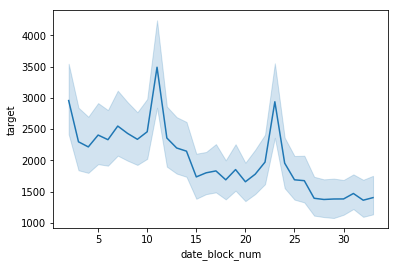

In [42]:
sns.lineplot(data=actual.groupby(['date_block_num', 'shop_id']).agg('sum').reset_index().astype('float'), x='date_block_num', y='target')

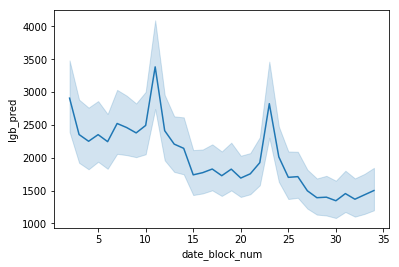

In [43]:
sns.lineplot(data=pred.groupby(['date_block_num', 'shop_id']).agg('sum').reset_index().astype('float'), x='date_block_num', y='lgb_pred')

In [100]:
pred['actual'] = actual['target']
pred

,date_block_num,shop_id,lgb_pred,group_id,shop_cluster,actual
722339,2,2,1.065247,5,5.0,1.0
722340,2,2,1.391348,5,5.0,1.0
722341,2,2,1.033883,16,5.0,1.0
722342,2,2,2.778710,16,5.0,2.0
722343,2,2,0.381707,16,5.0,1.0
...,...,...,...,...,...,...
214195,34,45,0.128012,11,0.0,NaN
214196,34,45,0.026772,9,0.0,NaN
214197,34,45,0.064347,11,0.0,NaN
214198,34,45,0.014650,5,0.0,NaN


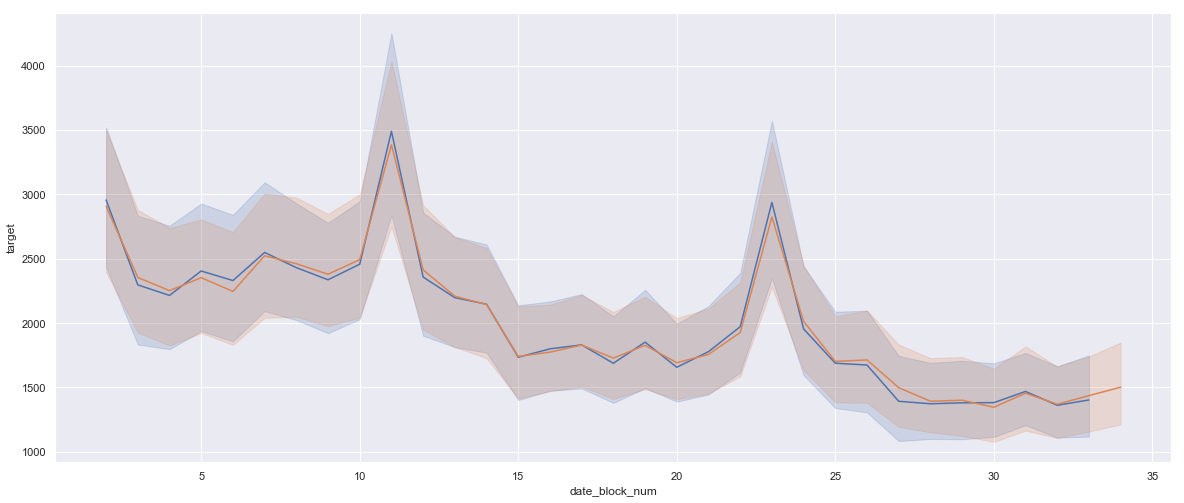

In [50]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,8.27)})

sns.lineplot(data=actual.groupby(['date_block_num', 'shop_id']).agg('sum').reset_index().astype('float'), x='date_block_num', y='target', ax=ax)
sns.lineplot(data=pred.groupby(['date_block_num', 'shop_id']).agg('sum').reset_index().astype('float'), x='date_block_num', y='lgb_pred', ax=ax)

In [55]:
actual

,date_block_num,shop_id,target,group_id,pred
722339,2,2,1,5,1.065247
722340,2,2,1,5,1.391348
722341,2,2,1,16,1.033883
722342,2,2,2,16,2.778710
722343,2,2,1,16,0.381707
...,...,...,...,...,...
10683916,33,59,1,0,0.084452
10683917,33,59,1,5,0.030372
10683918,33,59,1,5,0.078284
10683919,33,59,1,11,0.029121


In [101]:
temp1 = pred.drop(columns=['lgb_pred']).rename(columns={'actual':'sales'})
temp1['type'] = 'Actual Data'

temp2 = pred.drop(columns=['actual']).rename(columns={'lgb_pred':'sales'})
temp2['type'] = 'Prediction'

temp3 = pd.concat([temp1,temp2])


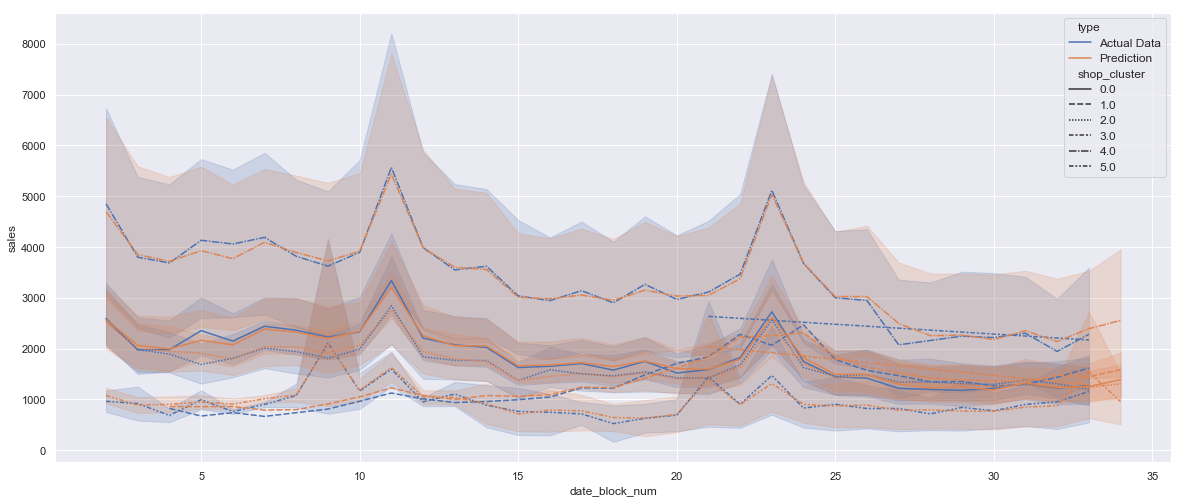

In [108]:
sns.lineplot(data=temp4.groupby(['date_block_num', 'type', 'shop_id', 'shop_cluster']).agg({'sales': 'sum'}).reset_index(), x="date_block_num", y="sales", hue="type", style='shop_cluster')

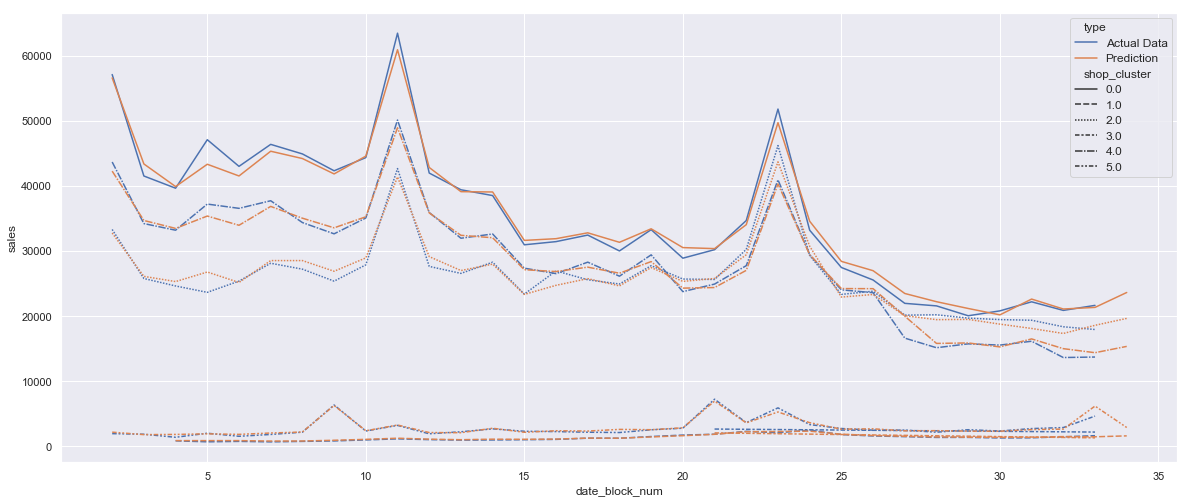

In [107]:
sns.lineplot(data=temp4.groupby(['date_block_num', 'type', 'shop_cluster']).agg({'sales': 'sum'}).reset_index(), x="date_block_num", y="sales", hue="type", style='shop_cluster')

In [102]:
temp4 = temp3.groupby(['date_block_num', 'shop_id', 'type', 'shop_cluster', 'group_id']).agg({'sales': 'sum'}).reset_index()

In [103]:
temp4[temp4['date_block_num'] == 34][temp4['type'] == 'Actual Data'].index

Int64Index([46090, 46091, 46092, 46093, 46094, 46095, 46096, 46097, 46098,
            46099,
            ...
            47491, 47492, 47493, 47494, 47495, 47496, 47497, 47498, 47499,
            47500],
           dtype='int64', length=714)

In [104]:
temp4 = temp4.drop(temp4[temp4['date_block_num'] == 34][temp4['type'] == 'Actual Data'].index)

In [105]:
temp4

,date_block_num,shop_id,type,shop_cluster,group_id,sales
0,2,2,Actual Data,5.0,0,27.000000
1,2,2,Actual Data,5.0,2,1.000000
2,2,2,Actual Data,5.0,3,11.000000
3,2,2,Actual Data,5.0,4,13.000000
4,2,2,Actual Data,5.0,5,92.000000
...,...,...,...,...,...,...
47513,34,59,Prediction,0.0,13,196.123709
47514,34,59,Prediction,0.0,14,4.116585
47515,34,59,Prediction,0.0,15,11.049299
47516,34,59,Prediction,0.0,16,16.672480


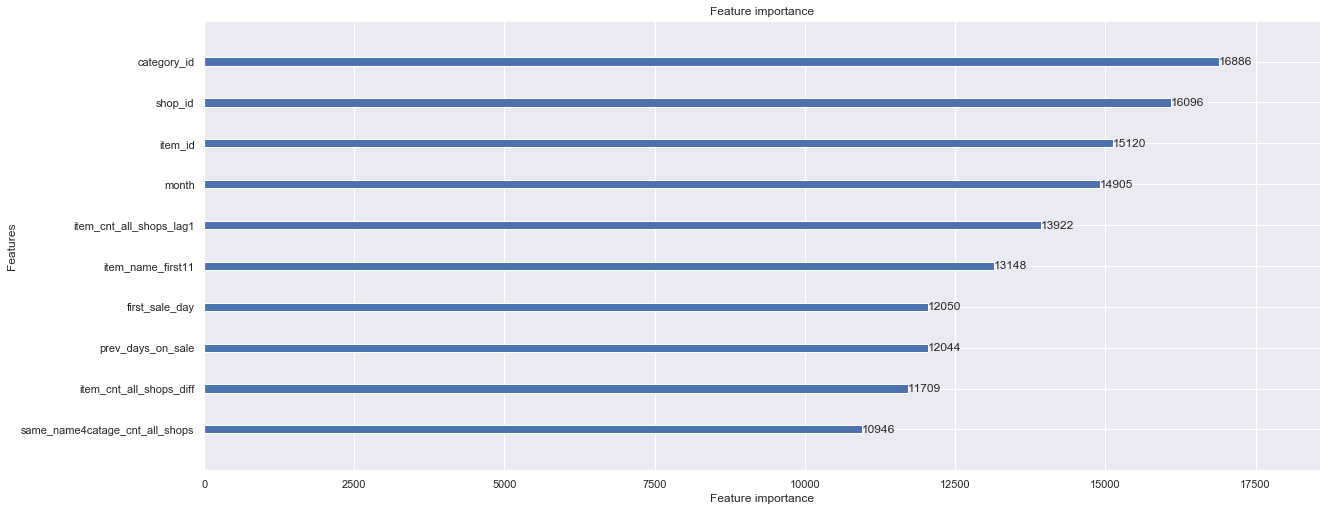

In [112]:
lgb.plot_importance(lgb_model, max_num_features=10)

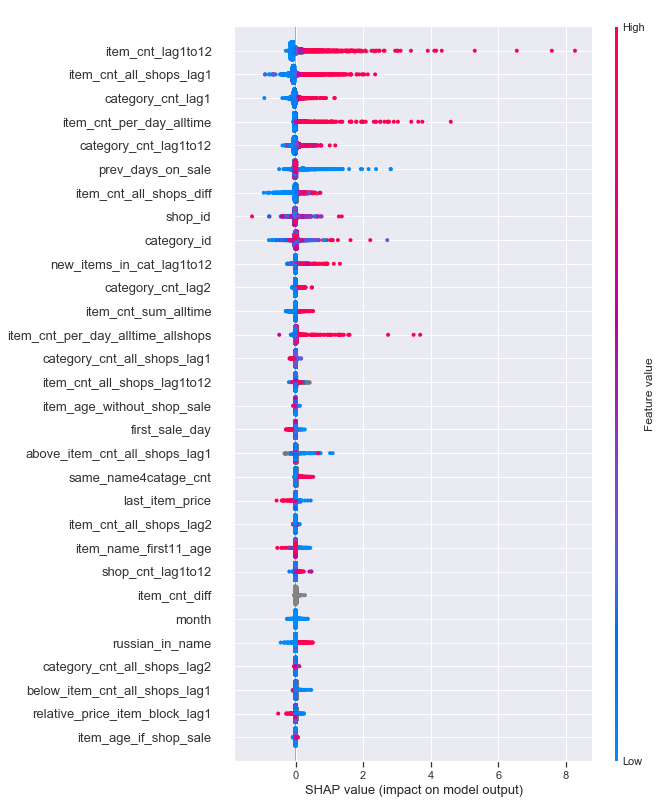

In [113]:
temp = X_test.drop(columns='lgb_pred').sample(10000)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(temp)
shap.summary_plot(shap_values, temp, max_display=30)

In [115]:
shops = pd.read_csv('./English/shops.csv')

In [126]:
temp4[temp4['shop_cluster']==4]

,date_block_num,shop_id,type,shop_cluster,group_id,sales
270,2,13,Actual Data,4.0,0,0.000000
271,2,13,Actual Data,4.0,2,0.000000
272,2,13,Actual Data,4.0,3,12.000000
273,2,13,Actual Data,4.0,4,55.000000
274,2,13,Actual Data,4.0,5,716.000000
...,...,...,...,...,...,...
47479,34,58,Prediction,4.0,13,201.692460
47480,34,58,Prediction,4.0,14,3.041745
47481,34,58,Prediction,4.0,15,16.912420
47482,34,58,Prediction,4.0,16,27.548045


In [141]:
del temp4['Cluster']
temp4.head()

,date_block_num,shop_id,type,shop_cluster,group_id,sales
0,2,2,Actual Data,5.0,0,27.0
1,2,2,Actual Data,5.0,2,1.0
2,2,2,Actual Data,5.0,3,11.0
3,2,2,Actual Data,5.0,4,13.0
4,2,2,Actual Data,5.0,5,92.0


In [138]:
mapdf = pd.DataFrame({'shop_cluster': [0.0,1.0,2.0,3.0,4.0,5.0], 'Cluster': ['Cinema and PC Games', 'PC Games', 'General', 'Gifts', 'Cinema', 'Games or Gifts']})

In [145]:
temp4 = temp4.merge(mapdf, on='shop_cluster')

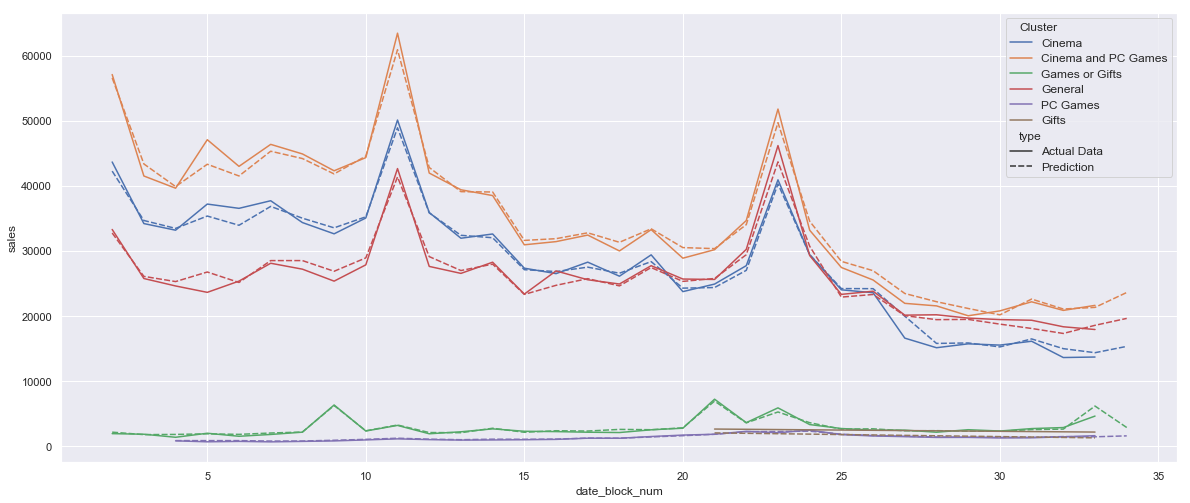

In [147]:
sns.lineplot(data=temp4.groupby(['date_block_num', 'type', 'Cluster']).agg({'sales': 'sum'}).reset_index(), x="date_block_num", y="sales", hue="Cluster", style='type')

In [153]:
top = temp4.query('Cluster == "Cinema" | Cluster == "Cinema and PC Games" | Cluster == "General"')
bot = temp4.query('Cluster == "Games or Gifts" | Cluster == "PC Games" | Cluster == "Gifts"')

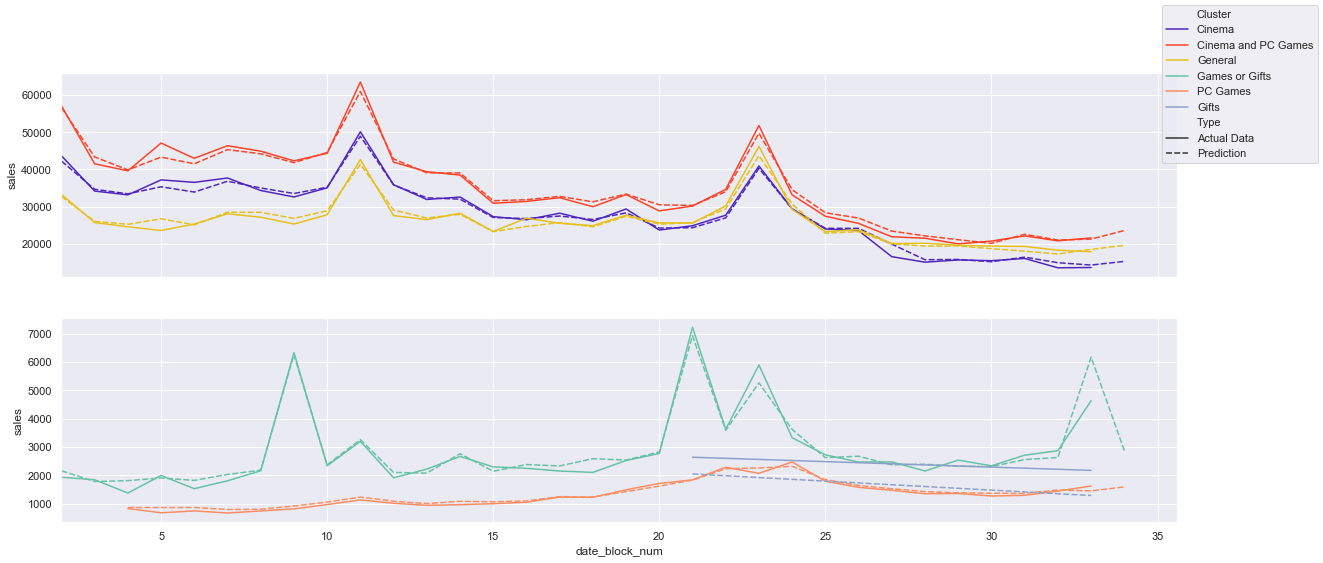

In [204]:
fig, axs = plt.subplots(2, sharex=True)
#fig.suptitle('Vertically stacked subplots')

palette1 = sns.color_palette("CMRmap", 3)
palette2 = sns.color_palette("Set2", 3)

sns.lineplot(data=top.groupby(['date_block_num', 'type', 'Cluster']).agg({'sales': 'sum'}).reset_index(), x="date_block_num", y="sales", hue="Cluster", style='type', ax=axs[0], palette=palette1, legend=False)
#axs[0].set(xticklabels=[]).set(xlabel=None).tick_params(left=False)
sns.lineplot(data=bot.groupby(['date_block_num', 'type', 'Cluster']).agg({'sales': 'sum'}).reset_index(), x="date_block_num", y="sales", hue="Cluster", style='type', ax=axs[1], palette=palette2, legend=False)

plt.xlim(left=2)

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines, labels)
plt.show()

fig.savefig('./outputs/trendline.png')

In [200]:
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

lines = lines[:4] + lines[8:]
labels = labels[:4] + labels[8:11] + ["Type"] + labels[12:]

In [201]:
lines

In [189]:
len(lines)

14

In [190]:
len(labels)

14

In [194]:
temp = labels[:4] + labels[8:11]
temp

['Cluster',
 'Cinema',
 'Cinema and PC Games',
 'General',
 'Games or Gifts',
 'PC Games',
 'Gifts',
 'type',
 'Actual Data',
 'Prediction']